## Noisy and Rotated Scanned Documents

### Problem Description

An insurance company is working on a system that can perform Optical Character Recognition (OCR) on documents from their archives. Unfortunately, their documents have been scanned at angles ranging from -5° to 5° from the horizontal. To increase OCR accuracy, they need a preprocessing step that determines the angle of a given page so this distortion can be corrected.

### Approach

The input of learning algorithm will be the scanned document images and the labels which are the different possible scanning angles.

Labels have been provided, treat with the problem as regression problem to get accurate result as much as possible.

**Here we are trying to solve this probelm using Classical approaches**Hough Transform

Using **Hough Transform** Algorithm to Detection and Correction Skewed Document  


### 1- Data Exploration

In [1]:
import numpy as np

import pytesseract
from pytesseract import image_to_string
from pytesseract import Output
from PIL import Image

from skimage.color import rgb2gray, gray2rgb
from skimage.draw import rectangle_perimeter
from skimage.transform import hough_line, hough_line_peaks, rotate
from skimage.feature import canny
from skimage.io import imread, imsave

import matplotlib.pyplot as plt
from scipy.stats import mode



import matplotlib.pyplot as plt


First testing OCR performance on one of samples of data

Using custom_config to OCR to improve the result

(566, 400, 3)
Words with more than 60% confident: 
['Surety', 'sed', 'dicta,', 'Nemo', 'est,', 'molestias', 'Jabore,', 'Omnis', '‘dolore', 'aut', 'sunt', 'aliquid.', 'sunt', 'ag', 'Duis', 'aperiam,', 'dolores', 'culpa', 'velit,', 'Provident,', 'placeat', 'voluptate', 'et', '‘atione', 'Neque']


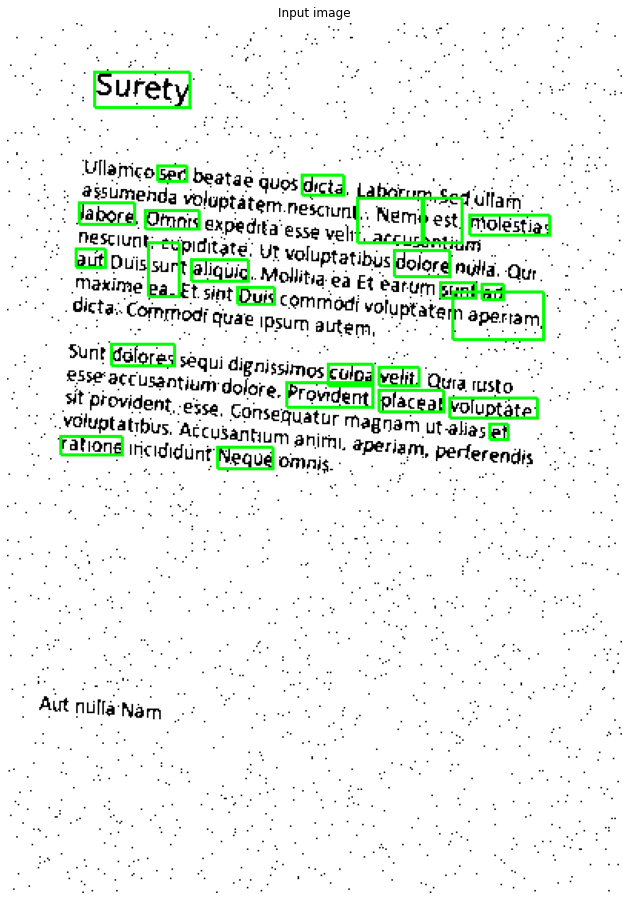

In [2]:
img = imread(r'scan_002.png')
img = gray2rgb(img)
print(img.shape)

h, w, c = img.shape


custom_config = r'--oem 3 --psm 6'

d = pytesseract.image_to_data(img, output_type=Output.DICT, config= custom_config)

res =[]
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        rr,cc = rectangle_perimeter(start =(x, y), extent = ( w,  h),shape=img.shape)
        # make rectangles more blod
        # swap w with h
        cc,rr=rr,cc
        img[ rr,cc, :] = [0, 255, 0] ## green Color 
        img[ rr-1,cc-1, :] = [0, 255, 0] ## green Color 
        
        
        
        res.append(d['text'][i])
print('Words with more than 60% confident: ')
print(res)

    # The following lines are required to display image in the notebook
fig, ax = plt.subplots(1, 1, figsize=(15, 16))
imsave('./Before rotation.png',img)

ax.imshow(img, cmap="gray")
ax.set_title('Input image')
ax.set_axis_off()


So poor performance on image :( 

Let's try another one 


(566, 400, 3)
Words with more than 60% confident: 
['Surety', 'aut.', 'velit', 'ut', 'Voluptates', 'perspiciatis', 'ipsum', 'earunt', 'quas.', 'Consequatur', 'énim', 'yel', 'ut', 'consequuntur', 'dolor', 'ot', 'deleniti', 'magnam', 'ad', 'Ea', 'tempore,', 'sed', 'molestiae', 'elt,', 'Nibit', 'excepturi', 'non', 'ea', '‘consequuntur', 'voluptatibus', 'ipsa', 'quis', 'repellat', 'ex', 'aut,', 'voluptate', 'labore’', 'Duis', 'bore', 'aut', 'rerum', 'rerum', 'Placeat', 'placeat', 'qua', 'et', 'atque,', 'Repudiandae', 'veniam,', ':']


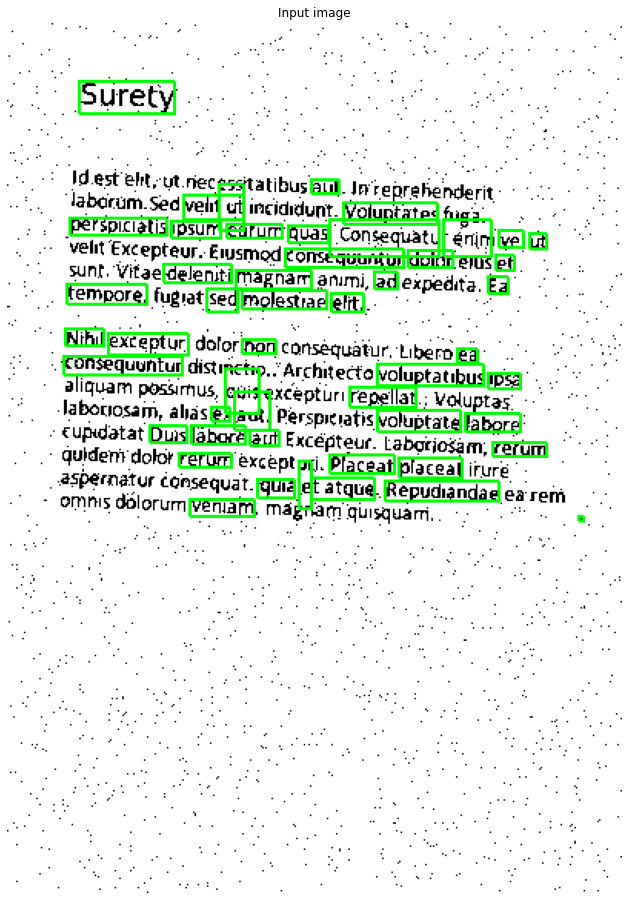

In [3]:
img = imread(r'scan_001.png')

img = gray2rgb(img)
print(img.shape)

h, w, c = img.shape


custom_config = r'--oem 3 --psm 6'

d = pytesseract.image_to_data(img, output_type=Output.DICT, config= custom_config)

res =[]
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        rr,cc = rectangle_perimeter(start =(x, y), extent = ( w,  h),shape=img.shape)
        # make rectangles more blod
        # swap w with h
        cc,rr=rr,cc
        img[ rr,cc, :] = [0, 255, 0] ## green Color 
        img[ rr-1,cc-1, :] = [0, 255, 0] ## green Color 
        
        
        
        res.append(d['text'][i])
print('Words with more than 60% confident: ')
print(res)

    # The following lines are required to display image in the notebook
fig, ax = plt.subplots(1, 1, figsize=(15, 16))
#gray_image = rgb2gray(img)

ax.imshow(img, cmap="gray")
ax.set_title('Input image')
ax.set_axis_off()

Looks better but note that this image Not skewd 

Let's fix that using classical approach **Hough Transform**

### 2- Apply Hough Transform

The document is angle 95.1°


Text(0.5, 1.0, 'Detected lines')

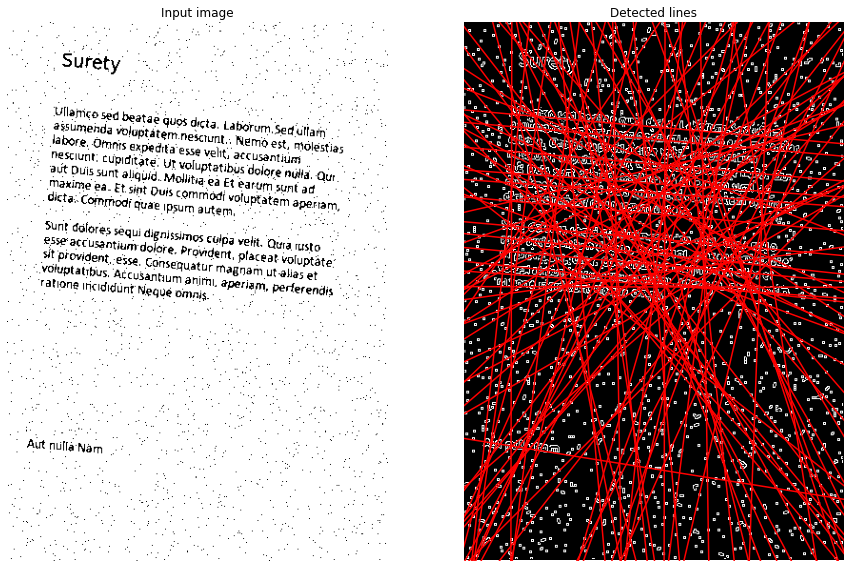

In [4]:
#%%timeit

image = imread(r'scan_002.png')
# Use canny edge detector
edges = canny(image)
# Classic straight-line Hough transform
tested_angles = np.deg2rad(np.arange(0.1, 180.0))
h, theta, d = hough_line(edges, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(15, 16))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(edges, cmap="gray")
origin = np.array((0, image.shape[1]))
angles=[]
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r')
    angles.append(angle)
#print(f"{mode(angles)[0][0]}")
print(f"The document is angle {np.rad2deg(mode(angles)[0][0])}{chr(176)}",)
#Choosing angle using vote
fixed_angle = -(90 - np.rad2deg(mode(angles)[0][0]))
ax[1].set_xlim(origin)
ax[1].set_ylim((edges.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

So the angel of doc equal 95.1 degree so to get back to origin need to rotate the image back in opposite direction with -5.1  degree base on this equation (90 - angle)

The cell execution time:

300 ms ± 38.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### 3- Result

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


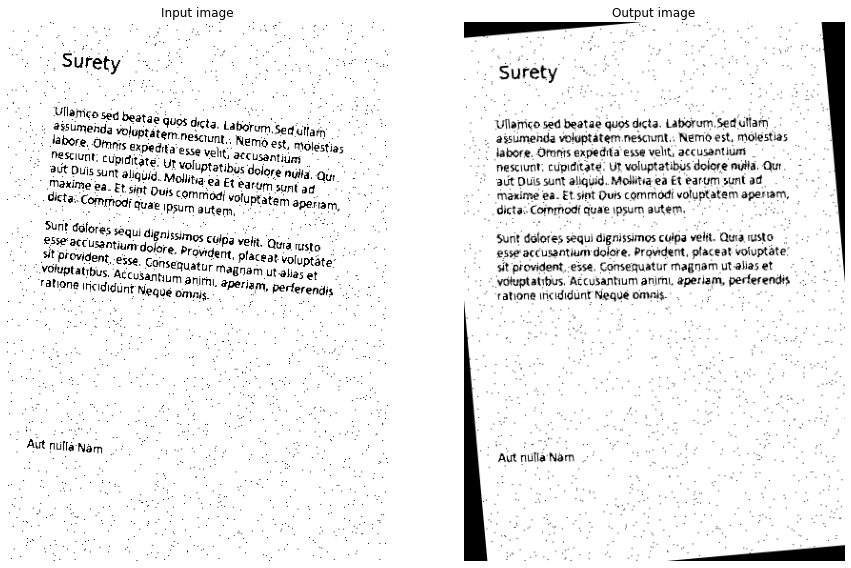

In [5]:
fixed_image = rotate(image, fixed_angle)

imsave('./fixed_image.png',fixed_image)
fig, axes = plt.subplots(1, 2, figsize=(15, 16))

ax = axes.ravel()
ax[0].imshow(image, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()
ax[1].imshow(fixed_image, cmap="gray")
ax[1].set_title('Output image')
ax[1].set_axis_off()

The true angle from label data : -4.72505826974727&deg;

The prediction angle equal : -5.1&deg;

Words with more than 60% confident: 
['Surety', 'aut.', 'velit', 'ut', 'Voluptates', 'perspiciatis', 'ipsum', 'earunt', 'quas.', 'Consequatur', 'énim', 'yel', 'ut', 'consequuntur', 'dolor', 'ot', 'deleniti', 'magnam', 'ad', 'Ea', 'tempore,', 'sed', 'molestiae', 'elt,', 'Nibit', 'excepturi', 'non', 'ea', '‘consequuntur', 'voluptatibus', 'ipsa', 'quis', 'repellat', 'ex', 'aut,', 'voluptate', 'labore’', 'Duis', 'bore', 'aut', 'rerum', 'rerum', 'Placeat', 'placeat', 'qua', 'et', 'atque,', 'Repudiandae', 'veniam,', ':', 'Surety', 'sed', 'beatae', 'quos', 'dicta.', 'ullam', 'est,', 'expedita', 'esse', 'velit,', 'Ut', 'voluptatibus', 'dolore', '‘aut', 'Duis', 'sunt', 'aliquid.', 'ea', 'Et', 'sunt', 'ea.', 'Quis', 'commiodi', 'voluptatem', 'Commodi', 'quae', 'Ipsum', 'Surit', 'sequi', 'dignissimos', 'velt.', 'dolore,', 'Provident,', 'placeat', 'sit', 'Consequatur', 'magnam', 'et', 'aperiam,', 'perferendis', 'Neque']


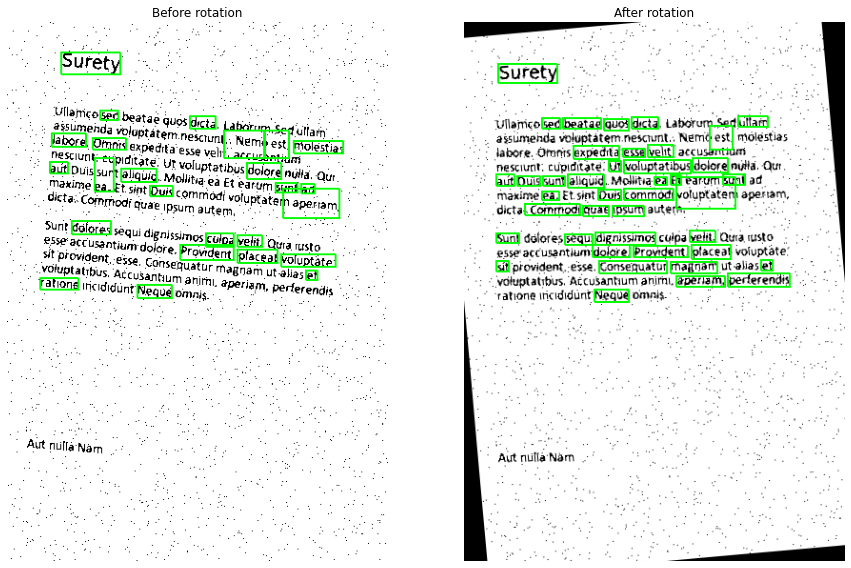

In [6]:
image = imread(r'Before rotation.png')
fixed_image = gray2rgb(imread(r'fixed_image.png'))

h, w, c = fixed_image.shape

custom_config = r'--oem 3 --psm 6'
d = pytesseract.image_to_data(fixed_image, output_type=Output.DICT, config= custom_config)

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        rr,cc = rectangle_perimeter(start =(x, y), extent = ( w,  h),shape=img.shape)
        cc,rr=rr,cc
        fixed_image[ rr,cc, :] = [0, 255, 0] ## green Color 
        fixed_image[ rr-1,cc-1, :] = [0, 255, 0] ## green Color  
        res.append(d['text'][i])
print('Words with more than 60% confident: ')
print(res)

fig, axes = plt.subplots(1, 2, figsize=(15, 16))

ax = axes.ravel()
ax[0].imshow(image, cmap="gray")
ax[0].set_title('Before rotation')
ax[0].set_axis_off()
ax[1].imshow(fixed_image, cmap="gray")
ax[1].set_title('After rotation')
ax[1].set_axis_off()

Note improvement in OCR performance after fix document


### 4- Conclusion

In this work we use Hough Transform to Detection and Correction Skewed Document as a preprocessing step aim to build OCR app with more accurate result